Import Libraries and Load the Dataset

In [58]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Load the dataset
df = pd.read_csv('american_bankruptcy.csv')

# Display the first few rows to understand the structure
print(df.head())

  company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12      X13      X14  \
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658  191.226  163.816   
1  18.531  115.187  ...   874.255  701.854  179.987  45.790  160.444  125.392   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711  112.244  150.464   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573  109.590  203.575   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811  128.656  131.261   

       X15       X16      X17   

Question 1 : Testing Collinear Problem

LDA Accuracy after removing specific columns: 0.93
QDA Accuracy after removing specific columns: 0.17


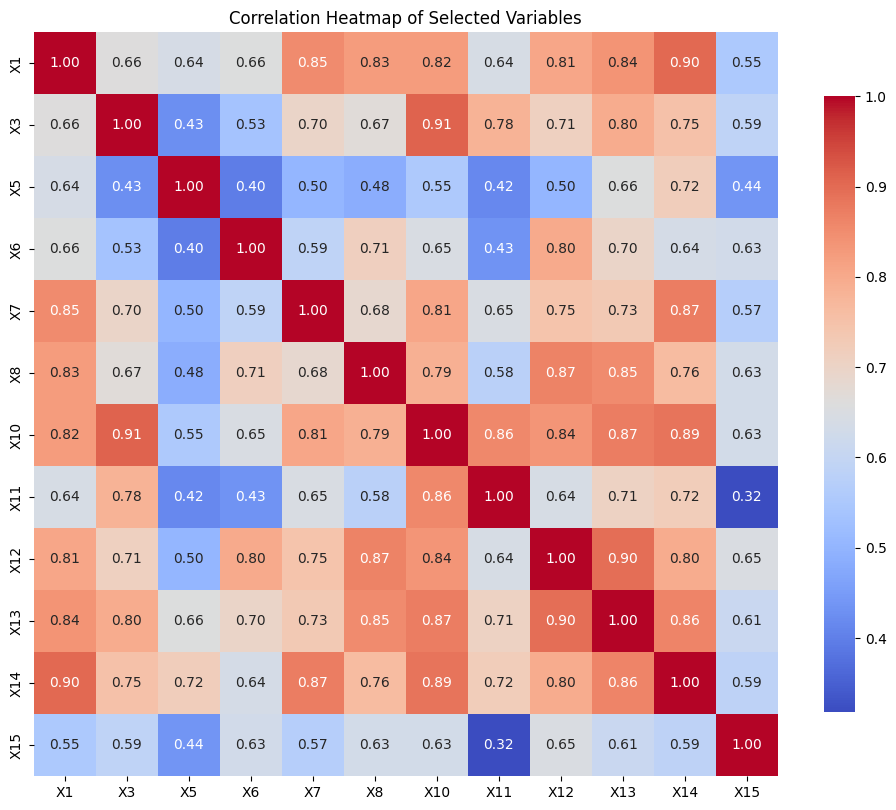

In [59]:


# Use the existing 'status_label' column (as provided in your dataset) to create the 'bankrupt' column
df['bankrupt'] = df['status_label'].map({'alive': 0, 'failed': 1})

# Step 1: Prepare the data by removing specific columns (X2, X4, X9, X16, X17, X18)
X_reduced = df[['X1', 'X3', 'X5', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15']]  # Remaining features after removal
y = df['bankrupt']  # The target variable

# Step 2: Split the data into training and testing sets
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Scale the reduced numeric data
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# Step 4: Re-train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled_reduced, y_train)
y_pred_lda = lda.predict(X_test_scaled_reduced)

# Evaluate LDA performance
lda_accuracy = accuracy_score(y_test, y_pred_lda)
print(f'LDA Accuracy after removing specific columns: {lda_accuracy:.2f}')

# Step 5: Re-train QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled_reduced, y_train)
y_pred_qda = qda.predict(X_test_scaled_reduced)

# Evaluate QDA performance
qda_accuracy = accuracy_score(y_test, y_pred_qda)
print(f'QDA Accuracy after removing specific columns: {qda_accuracy:.2f}')

# Step 6: Calculate the correlation matrix for selected features
corr_matrix = df[['X1', 'X3', 'X5', 'X6', 'X7', 'X8',  
                  'X10', 'X11', 'X12', 'X13', 'X14', 'X15']].corr()

# Step 7: Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

# Customize the plot
plt.title('Correlation Heatmap of Selected Variables')
plt.show()

Question 2: Adjusting Variables

Feature Engineering - Altman Z-score Calculation

In [60]:
# Rename the columns as per the provided mapping
df.rename(columns={
    'X1':'Current assets',
    'X2':'Cost of goods sold',
    'X3':'Depreciation and amortization',
    'X4':'EBITDA',
    'X5':'Inventory',
    'X6':'Net Income',
    'X7':'Total Receivables',
    'X8':'Market value',
    'X9':'Net sales',
    'X10':'Total assets',
    'X11':'Total Long-term debt',
    'X12':'EBIT',
    'X13':'Gross Profit',
    'X14':'Total Current Liabilities',
    'X15':'Retained Earnings',
    'X16':'Total Revenue',
    'X17':'Total Liabilities',
    'X18':'Total Operating Expenses'
}, inplace=True)

LDA Accuracy with Altman Z-score: 0.93
QDA Accuracy with Altman Z-score: 0.09


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LDA Accuracy after PCA: 0.93
QDA Accuracy after PCA: 0.10


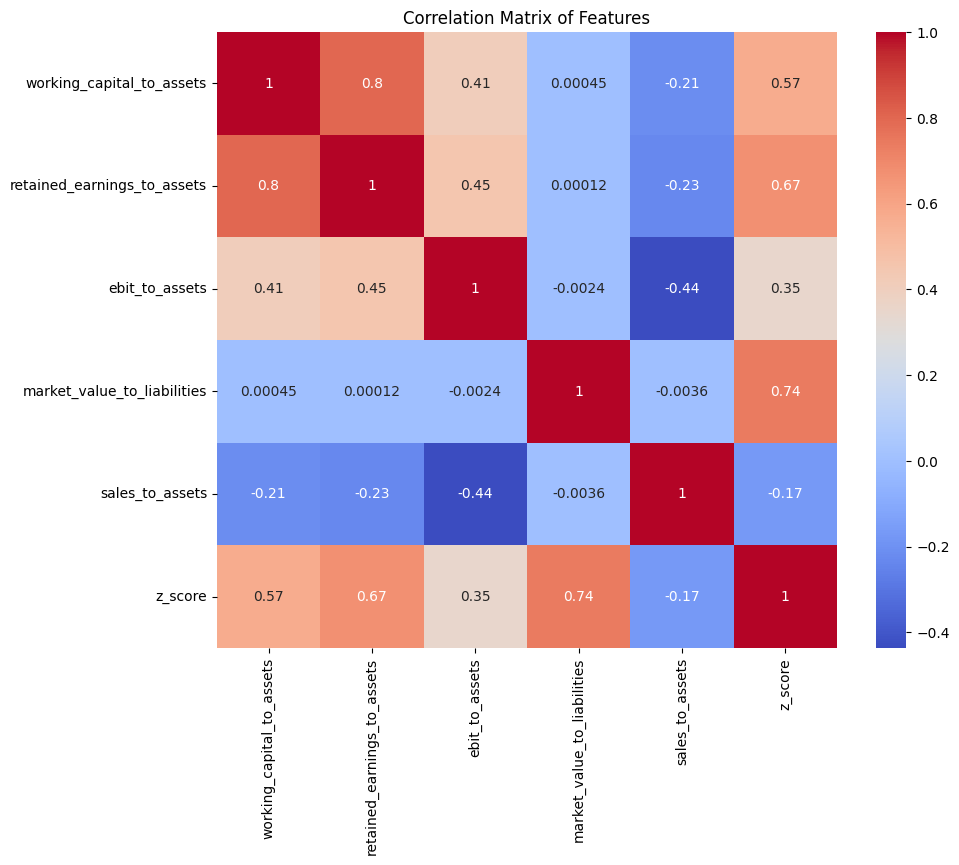

In [61]:
# create Altman Z-score varible
df['working_capital_to_assets'] = (df['Current assets'] - df['Total Current Liabilities']) / df['Total assets']
df['retained_earnings_to_assets'] = df['Retained Earnings'] / df['Total assets']
df['ebit_to_assets'] = df['EBIT'] / df['Total assets']
df['market_value_to_liabilities'] = df['Market value'] / df['Total Liabilities']
df['sales_to_assets'] = df['Net sales'] / df['Total assets']

# Caculate Altman Z-score
df['z_score'] = 1.2 * df['working_capital_to_assets'] + 1.4 * df['retained_earnings_to_assets'] + \
                3.3 * df['ebit_to_assets'] + 0.6 * df['market_value_to_liabilities'] + \
                1.0 * df['sales_to_assets']

#  Z-score model
X = df[['working_capital_to_assets', 'retained_earnings_to_assets', 'ebit_to_assets', 
        'market_value_to_liabilities', 'sales_to_assets', 'z_score']]  
y = df['bankrupt'] 

# class the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# training LDA 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)
lda_accuracy = accuracy_score(y_test, y_pred_lda)
print(f'LDA Accuracy with Altman Z-score: {lda_accuracy:.2f}')

#  training QDA 
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)
qda_accuracy = accuracy_score(y_test, y_pred_qda)
print(f'QDA Accuracy with Altman Z-score: {qda_accuracy:.2f}')

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)  # Choose a lower number of components to avoid collinearity
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Re-train LDA and QDA on PCA-transformed data
lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(X_train_pca, y_train)
y_pred_lda_pca = lda_pca.predict(X_test_pca)
lda_accuracy_pca = accuracy_score(y_test, y_pred_lda_pca)
print(f'LDA Accuracy after PCA: {lda_accuracy_pca:.2f}')

qda_pca = QuadraticDiscriminantAnalysis()
qda_pca.fit(X_train_pca, y_train)
y_pred_qda_pca = qda_pca.predict(X_test_pca)
qda_accuracy_pca = accuracy_score(y_test, y_pred_qda_pca)
print(f'QDA Accuracy after PCA: {qda_accuracy_pca:.2f}')

# Calculate the correlation matrix
corr_matrix = df[['working_capital_to_assets', 'retained_earnings_to_assets', 'ebit_to_assets', 
                  'market_value_to_liabilities', 'sales_to_assets', 'z_score']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()



Finding Some better Ratio

In [62]:
# Check the actual column names before renaming
print(df.columns)

Index(['company_name', 'status_label', 'year', 'Current assets',
       'Cost of goods sold', 'Depreciation and amortization', 'EBITDA',
       'Inventory', 'Net Income', 'Total Receivables', 'Market value',
       'Net sales', 'Total assets', 'Total Long-term debt', 'EBIT',
       'Gross Profit', 'Total Current Liabilities', 'Retained Earnings',
       'Total Revenue', 'Total Liabilities', 'Total Operating Expenses',
       'bankrupt', 'working_capital_to_assets', 'retained_earnings_to_assets',
       'ebit_to_assets', 'market_value_to_liabilities', 'sales_to_assets',
       'z_score'],
      dtype='object')


LDA Accuracy with initial ratios: 0.93
QDA Accuracy with initial ratios: 0.11
LDA Accuracy with new combined ratios: 0.93
QDA Accuracy with new combined ratios: 0.09


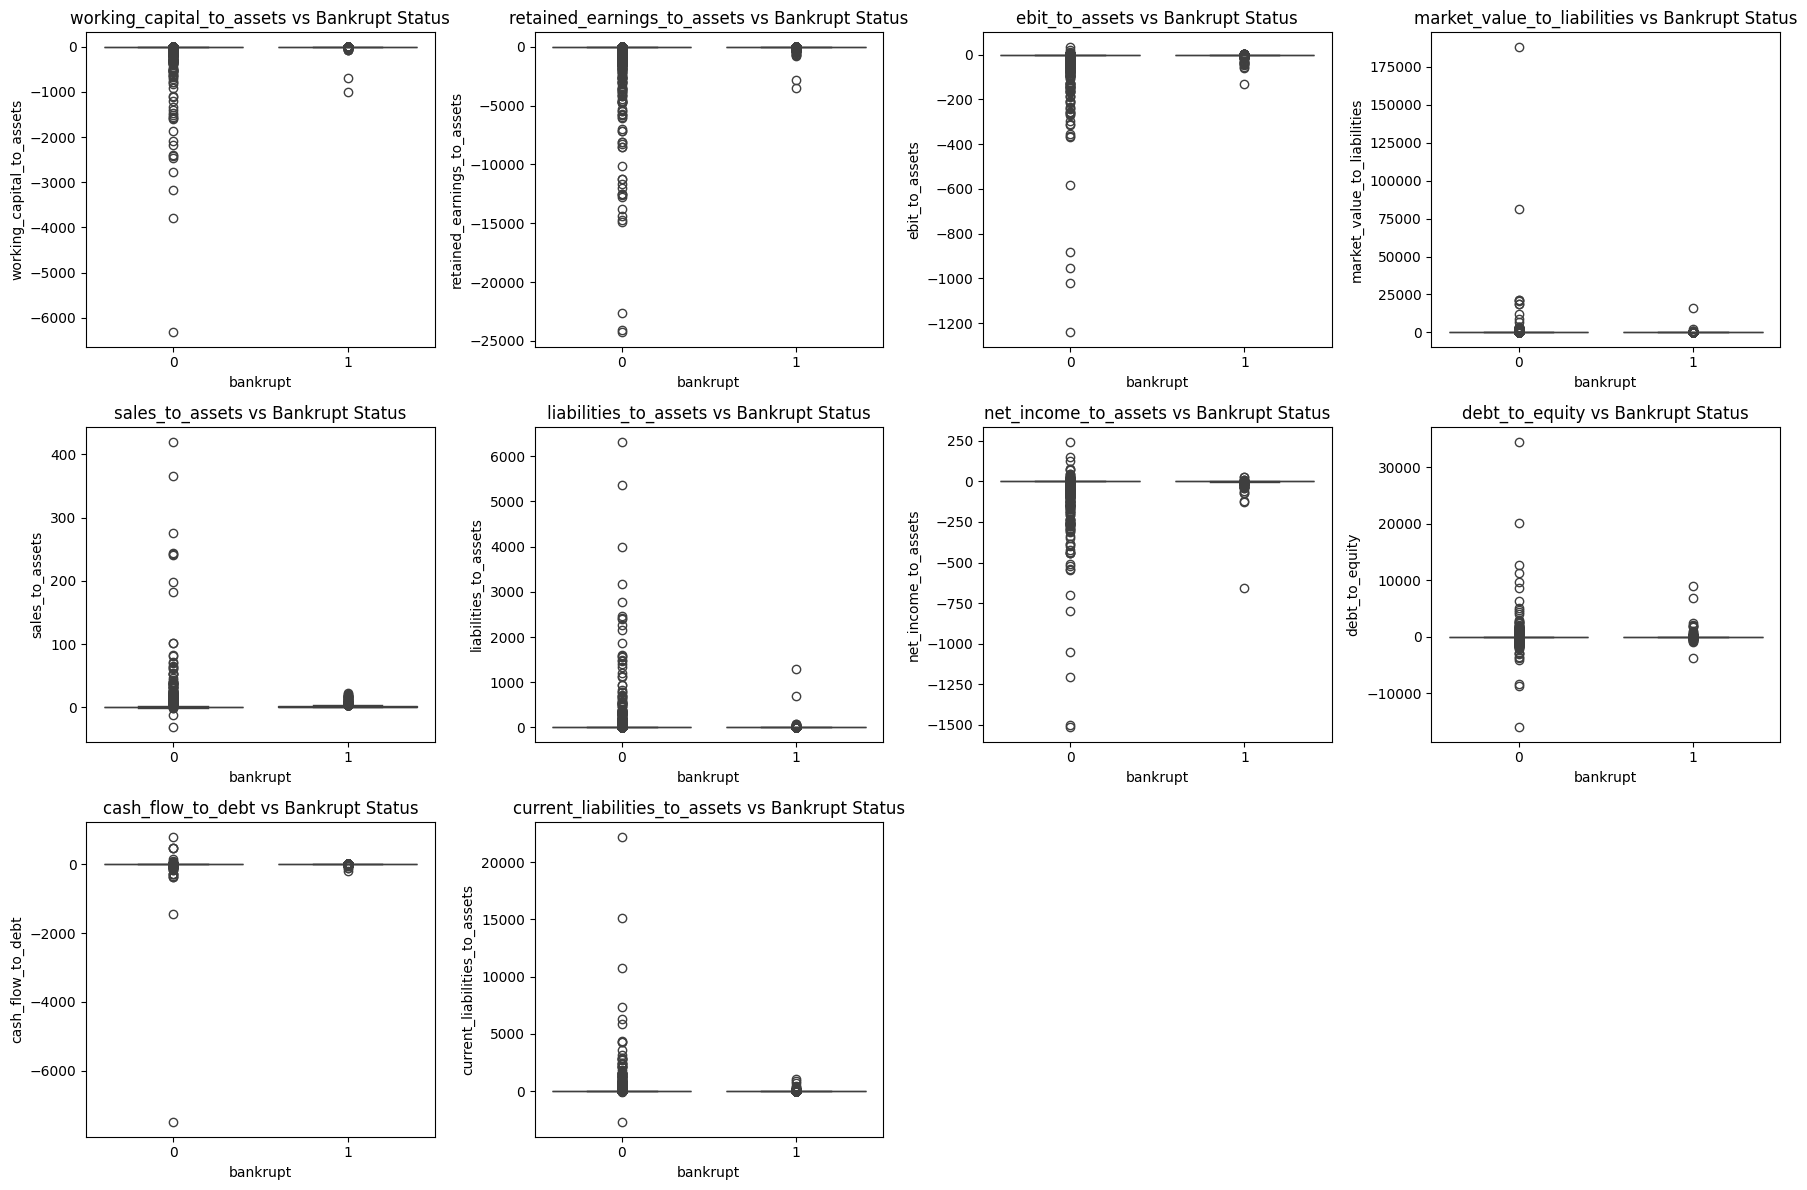

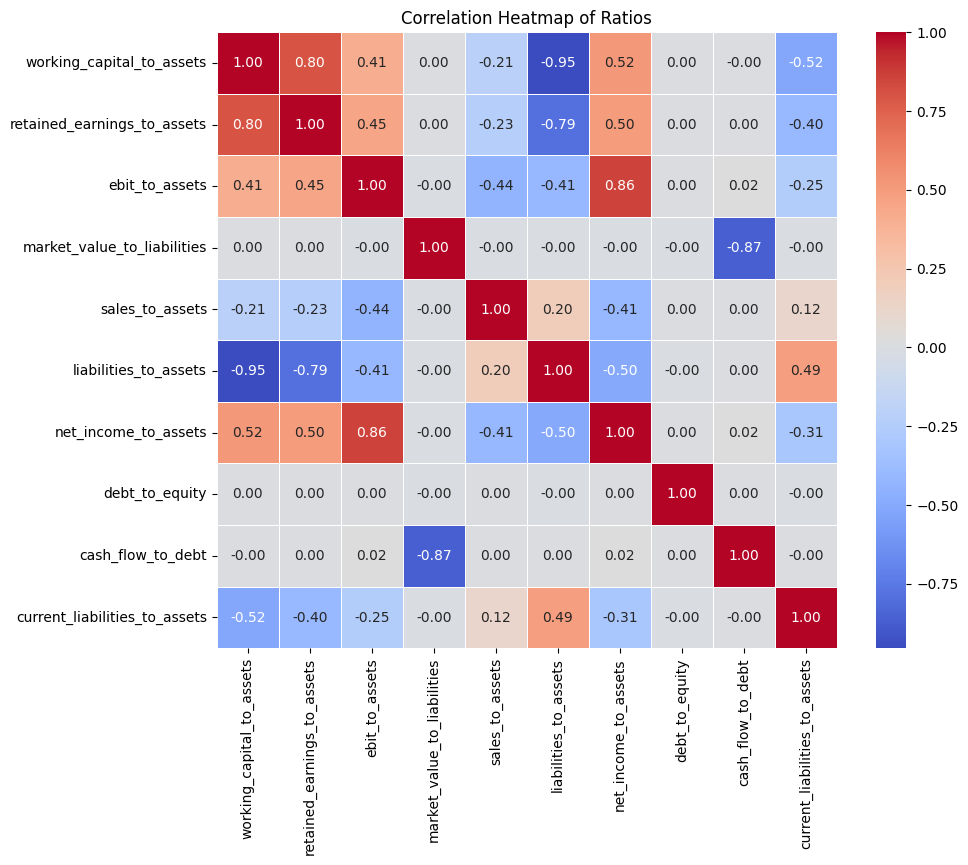

In [63]:
# Step 2: Create initial financial ratios using correct column names
df['current_ratio'] = df['Current assets'] / df['Total Current Liabilities']
df['quick_ratio'] = (df['Current assets'] - df['Inventory']) / df['Total Current Liabilities']
df['debt_to_asset_ratio'] = df['Total Liabilities'] / df['Total assets']
df['equity_to_asset_ratio'] = df['Retained Earnings'] / df['Total assets']
df['debt_to_equity_ratio'] = df['Total Liabilities'] / df['Retained Earnings']

# Step 3: Use the new ratios for modeling
X = df[['current_ratio', 'quick_ratio', 'debt_to_asset_ratio', 
        'equity_to_asset_ratio', 'debt_to_equity_ratio']]
y = df['bankrupt']  # Target variable

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)

# Step 7: Evaluate LDA performance
lda_accuracy = accuracy_score(y_test, y_pred_lda)
print(f'LDA Accuracy with initial ratios: {lda_accuracy:.2f}')

# Step 8: Train QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)

# Step 9: Evaluate QDA performance
qda_accuracy = accuracy_score(y_test, y_pred_qda)
print(f'QDA Accuracy with initial ratios: {qda_accuracy:.2f}')

# Step 10: Create additional combined ratios based on available financial data
df['working_capital_to_assets'] = (df['Current assets'] - df['Total Current Liabilities']) / df['Total assets']
df['retained_earnings_to_assets'] = df['Retained Earnings'] / df['Total assets']
df['ebit_to_assets'] = df['EBIT'] / df['Total assets']
df['market_value_to_liabilities'] = df['Market value'] / df['Total Liabilities']
df['sales_to_assets'] = df['Net sales'] / df['Total assets']
df['liabilities_to_assets'] = df['Total Liabilities'] / df['Total assets']
df['net_income_to_assets'] = df['Net Income'] / df['Total assets']
df['debt_to_equity'] = df['Total Liabilities'] / df['Retained Earnings']
df['cash_flow_to_debt'] = df['Net Income'] / df['Total Liabilities']
df['current_liabilities_to_assets'] = df['Total Current Liabilities'] / df['Current assets']

# Step 11: Select these new ratios for modeling
X_new = df[['working_capital_to_assets', 'retained_earnings_to_assets', 'ebit_to_assets', 
            'market_value_to_liabilities', 'sales_to_assets', 'liabilities_to_assets',
            'net_income_to_assets', 'debt_to_equity', 'cash_flow_to_debt', 'current_liabilities_to_assets']]

# Step 12: Train-test split with new ratios
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.3, random_state=42)

# Step 13: Standardize the new data
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)

# Step 14: Train LDA model with new ratios
lda.fit(X_train_scaled_new, y_train_new)
y_pred_lda_new = lda.predict(X_test_scaled_new)

# Step 15: Evaluate LDA performance with new ratios
lda_accuracy_new = accuracy_score(y_test_new, y_pred_lda_new)
print(f'LDA Accuracy with new combined ratios: {lda_accuracy_new:.2f}')

# Step 16: Train QDA model with new ratios
qda.fit(X_train_scaled_new, y_train_new)
y_pred_qda_new = qda.predict(X_test_scaled_new)

# Step 17: Evaluate QDA performance with new ratios
qda_accuracy_new = accuracy_score(y_test_new, y_pred_qda_new)
print(f'QDA Accuracy with new combined ratios: {qda_accuracy_new:.2f}')

# Step 18: Boxplots for each ratio against 'bankrupt' status
plt.figure(figsize=(18, 12))
for i, ratio in enumerate(X_new.columns):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=y, y=df[ratio])
    plt.title(f'{ratio} vs Bankrupt Status')

plt.tight_layout()
plt.show()

# Step 19: Correlation Heatmap of the combined ratios
plt.figure(figsize=(10, 8))
corr_matrix = df[['working_capital_to_assets', 'retained_earnings_to_assets', 'ebit_to_assets', 
                  'market_value_to_liabilities', 'sales_to_assets', 'liabilities_to_assets',
                  'net_income_to_assets', 'debt_to_equity', 'cash_flow_to_debt', 'current_liabilities_to_assets']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Ratios')
plt.show()

Trying other model

Logistic Regression Accuracy: 0.93
Random Forest Accuracy: 0.93


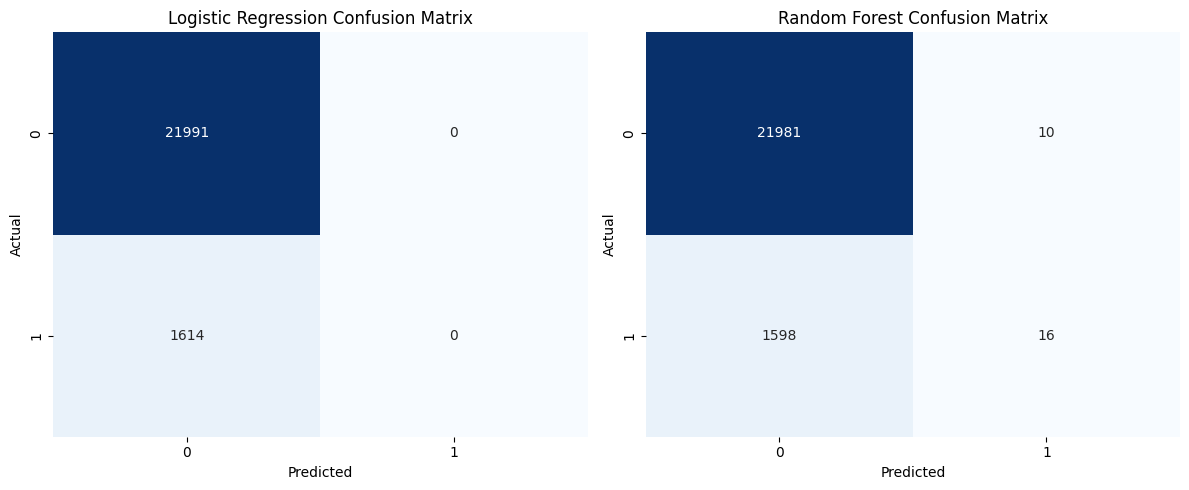

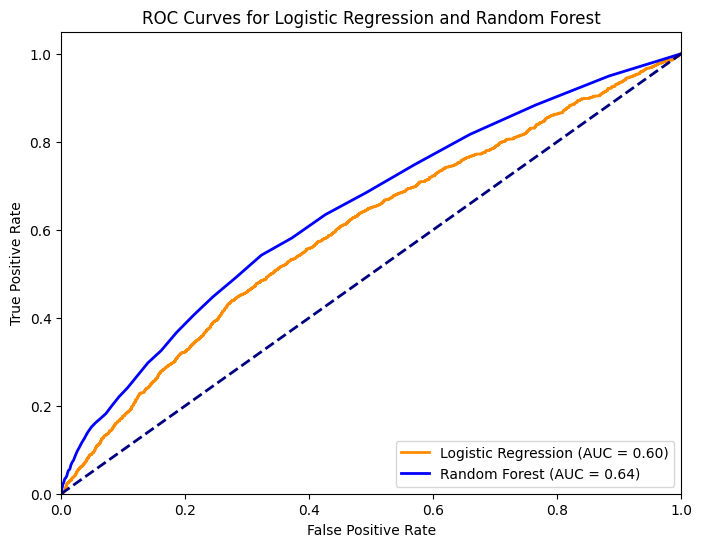

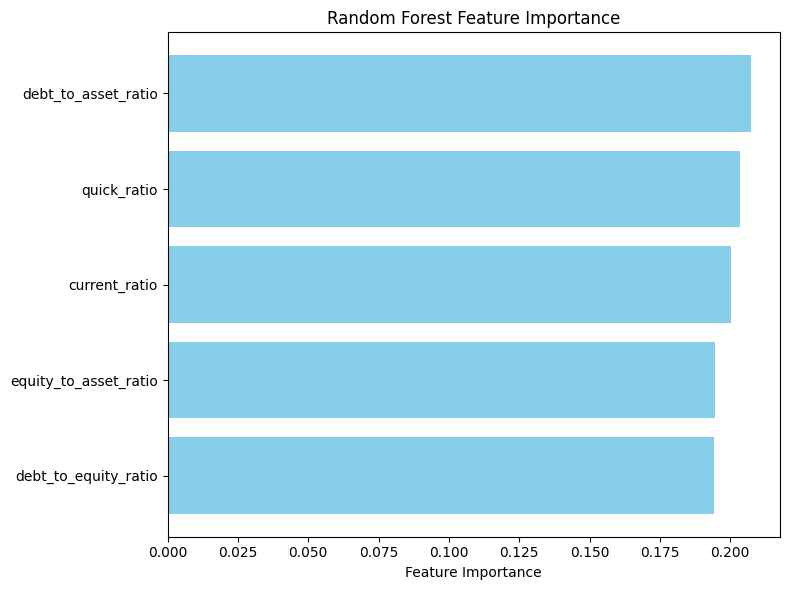

In [65]:

# Assuming X_train, X_test, y_train, y_test are already defined
# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate Logistic Regression model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {log_reg_accuracy:.2f}')

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

# Confusion Matrix, ROC Curve, and Feature Importance for both models

# Function to plot confusion matrices for both Logistic Regression and Random Forest
def plot_combined_confusion_matrix(y_test, y_pred_log_reg, y_pred_rf):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Logistic Regression Confusion Matrix
    cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
    sns.heatmap(cm_log_reg, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title('Logistic Regression Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Random Forest Confusion Matrix
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
    axes[1].set_title('Random Forest Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# Function to plot ROC Curves for both Logistic Regression and Random Forest
def plot_combined_roc_curve(log_reg, rf, X_test_scaled, y_test):
    plt.figure(figsize=(8, 6))
    
    # Logistic Regression ROC Curve
    y_pred_prob_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
    fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_prob_log_reg)
    roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
    plt.plot(fpr_log_reg, tpr_log_reg, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')

    # Random Forest ROC Curve
    y_pred_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Logistic Regression and Random Forest')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot feature importance for Random Forest
def plot_feature_importance_combined(model, X_train):
    importance = model.feature_importances_
    feature_names = X_train.columns
    sorted_idx = importance.argsort()
    
    plt.figure(figsize=(8, 6))
    plt.barh(feature_names[sorted_idx], importance[sorted_idx], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

# Combine the above figures for both models
plot_combined_confusion_matrix(y_test, y_pred_log_reg, y_pred_rf)
plot_combined_roc_curve(log_reg, rf, X_test_scaled, y_test)
plot_feature_importance_combined(rf, X_train)  # Only for Random Forest